# 3
- extract a feature vector for an image
- KMeans, AgglomerativeClustering
- PCA, TruncatedSVD

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torchsummary import summary
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
path = 'W:\\datasets\\asbestos\\line-segmentation\\'
os.listdir(path)

['aug_images_224',
 'aug_masks_224',
 'images',
 'images_encoder',
 'images_encoder0',
 'images_encoder1',
 'macro_fullsize.xml',
 'masks',
 'masks_encoder',
 'v1']

In [4]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'aug_images_224':
        img_pathes = pathes
    elif folder == 'aug_masks_224':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [6]:
len(img_pathes)

500

In [7]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

In [18]:
images = []
for img in img_pathes:
    images.append(T(Image.open(img)))

masks = []
for mask in lbl_pathes:
    masks.append(T(Image.open(mask)))

In [41]:
int(bool(sum(masks[2].view(-1)).item()))

1

In [39]:
answers = []
for i in range(len(lbl_pathes)):
    if sum(masks[i].view(-1)).item():
        answers.append(1)
    else:
        answers.append(0)

In [43]:
def get_vectors(model = 'resnet34'):
    if model == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model == 'resnet34':
        model = models.resnet34(pretrained=True)
    elif model == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
    elif model == 'densenet201':
        model = models.densenet201(pretrained=True)
    elif model =='alexnet':
        model = models.alexnet(pretrained=True)
    elif model == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif model == 'resnext101_32x8d':
        model = models.resnext101_32x8d(pretrained=True)
    elif model == 'squeezenet1_1':
        model = models.squeezenet1_1(pretrained=True)
    elif model == 'wide_resnet101_2':
        model = models.wide_resnet101_2(pretrained=True)  
    elif model == 'vgg16':
        model = models.vgg16(pretrained=True)    
        
    #model = models.resnet34(pretrained=True)
    model.eval()

    scaler = transforms.Resize((224, 224))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    to_tensor = transforms.ToTensor()

    ### strip the last layer
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]) #magic
    vectors = []
    for i in img_pathes:
        img = Image.open(i)
        t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
        vectors.append(feature_extractor(t_img).view(-1).detach().numpy())
    return vectors

In [7]:
#summary(model.cuda(), (3, 224, 224))

In [8]:
#answers = [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]

# KMeans & AgglomerativeClustering

In [52]:
def kmeans_ac(vectors):
    #print(answers, "gt   ")
    kmeans = KMeans(n_clusters=2, random_state=42).fit(vectors)
    predictions = kmeans.labels_
    eq = sum(predictions == answers)
    neq = sum(predictions != answers)

    print(" KMeans ", eq,"-", neq, '-', eq/(eq+neq)*100) # или наоборот

    ac = AgglomerativeClustering(n_clusters=2).fit(vectors)
    predictions = ac.labels_
    eq = sum(predictions == answers)
    neq = sum(predictions != answers)
    print(" AgglomerativeClustering", eq,"-", neq, '-', eq/(eq+neq)*100)


# PCA & SVD

In [86]:
def plot_PCA_SVD(vectors): 
    x1_pca, y1_pca, x2_pca, y2_pca = PCA_SVD(vectors, 'pca')
    x1_svd, y1_svd, x2_svd, y2_svd = PCA_SVD(vectors, 'svd')
    
    x1_pca_mean, y1_pca_mean = np.mean(x1_pca), np.mean(y1_pca)
    x2_pca_mean, y2_pca_mean = np.mean(x2_pca), np.mean(y2_pca)
    x1_svd_mean, y1_svd_mean = np.mean(x1_svd), np.mean(y1_svd)
    x2_svd_mean, y2_svd_mean = np.mean(x2_svd), np.mean(y2_svd)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('PCA')
    plt.scatter(x1_pca, y1_pca, color ='m', label='1')
    plt.scatter(x2_pca, y2_pca, color = 'c', label='0')
    plt.scatter(x1_pca_mean, y1_pca_mean, color = 'r', s = 200, label='1 center')
    plt.scatter(x2_pca_mean, y2_pca_mean, color = 'b', s = 200, label='0 center')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title('SVD')
    plt.scatter(x1_svd, y1_svd, color = 'm', label='1')
    plt.scatter(x2_svd, y2_svd, color = 'c', label='0')
    plt.scatter(x1_svd_mean, y1_svd_mean, color = 'r', s = 200, label='1 center')
    plt.scatter(x2_svd_mean, y2_svd_mean, color = 'b', s = 200, label='0 center')    
    plt.legend()
    plt.show()

In [87]:
def PCA_SVD(vectors, alg):
    if alg == 'pca':
        pca = PCA(n_components=2, random_state=42).fit(vectors)
        print("PCA explained variance ratio ", pca.explained_variance_ratio_)
        print("PCA singular values          ", pca.singular_values_)
        X = pca.transform(vectors)
    elif alg == 'svd':
        svd = TruncatedSVD(n_components=2, random_state=42).fit(vectors)
        print("SVD explained variance ratio ", svd.explained_variance_ratio_)
        print("SVD singular values          ", svd.singular_values_)
        X = svd.transform(vectors)
    x1, x2, y1, y2 = [], [], [], []
    for i, (xi, yi) in enumerate(zip(X[:, 0], X[:, 1])):
        (x1.append(xi), y1.append(yi)) if answers[i] else (x2.append(xi), y2.append(yi))
    return x1, y1, x2, y2

# nets

===== resnet18 =====
PCA explained variance ratio  [0.18043512 0.10825587]
PCA singular values           [91.60572389 70.95578392]
SVD explained variance ratio  [0.06047033 0.15160966]
SVD singular values           [393.5599   84.23923]


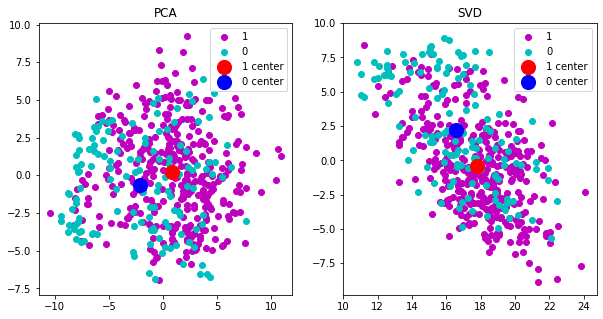

 KMeans  342 - 158 - 68.4
 AgglomerativeClustering 142 - 358 - 28.4
===== resnet34 =====
PCA explained variance ratio  [0.18524772 0.09986889]
PCA singular values           [109.62184252  80.48885923]
SVD explained variance ratio  [0.07247379 0.14493799]
SVD singular values           [457.35916  97.40548]


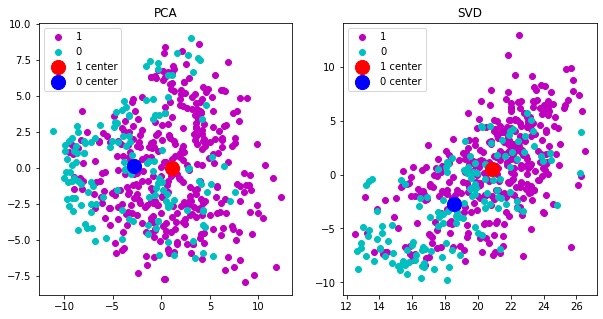

 KMeans  186 - 314 - 37.2
 AgglomerativeClustering 131 - 369 - 26.200000000000003
===== resnet50 =====
PCA explained variance ratio  [0.18482342 0.13410172]
PCA singular values           [109.8636482   93.58208133]
SVD explained variance ratio  [0.06954218 0.14208587]
SVD singular values           [491.82718   96.673546]


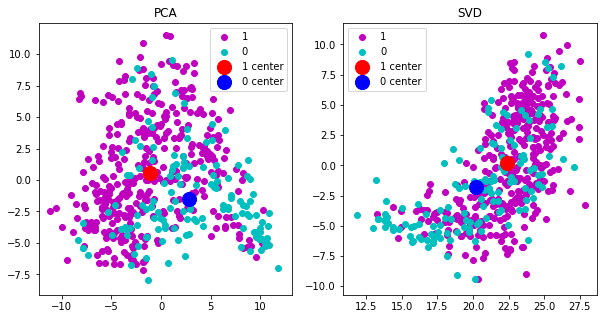

 KMeans  176 - 324 - 35.199999999999996
 AgglomerativeClustering 247 - 253 - 49.4
===== mobilenet_v2 =====
PCA explained variance ratio  [0.07089717 0.04185366]
PCA singular values           [687.1044521  527.92840497]
SVD explained variance ratio  [0.02232078 0.05965349]
SVD singular values           [2653.547   632.9154]


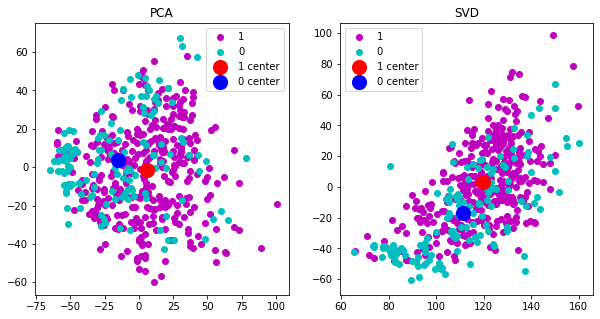

 KMeans  310 - 190 - 62.0
 AgglomerativeClustering 154 - 346 - 30.8
===== densenet201 =====
PCA explained variance ratio  [0.05155745 0.03555985]
PCA singular values           [943.32363599 783.4205174 ]
SVD explained variance ratio  [0.01182324 0.04854819]
SVD singular values           [3309.306   916.9653]


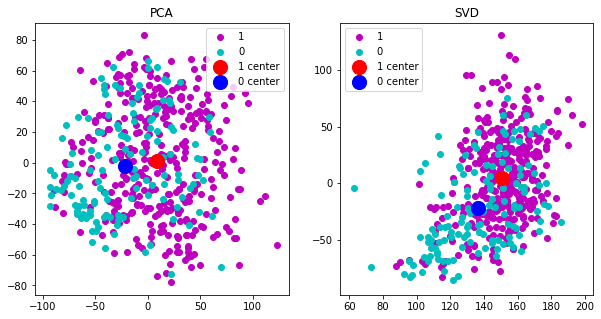

 KMeans  213 - 287 - 42.6
 AgglomerativeClustering 259 - 241 - 51.800000000000004
===== alexnet =====
PCA explained variance ratio  [0.07774898 0.0458677 ]
PCA singular values           [426.62708794 327.68347706]
SVD explained variance ratio  [0.02475019 0.06918167]
SVD singular values           [1524.3801  403.6385]


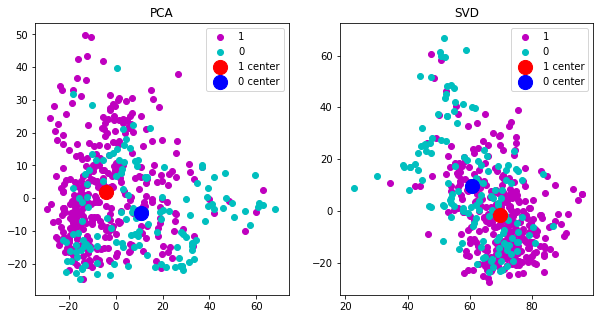

 KMeans  142 - 358 - 28.4
 AgglomerativeClustering 139 - 361 - 27.800000000000004
===== resnet152 =====
PCA explained variance ratio  [0.17564317 0.11181846]
PCA singular values           [115.16759196  91.89066603]
SVD explained variance ratio  [0.06884062 0.14022551]
SVD singular values           [490.4039  103.26355]


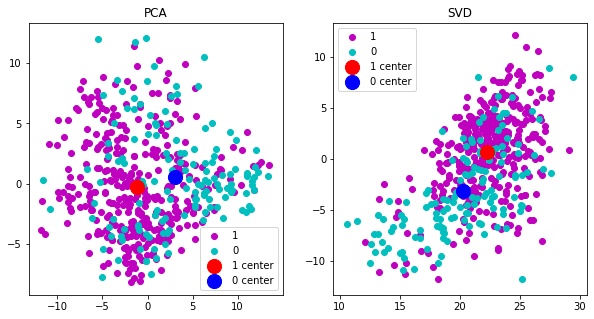

 KMeans  156 - 344 - 31.2
 AgglomerativeClustering 240 - 260 - 48.0
===== resnext101_32x8d =====
PCA explained variance ratio  [0.17035701 0.09392416]
PCA singular values           [138.96310373 103.18300281]
SVD explained variance ratio  [0.06969489 0.13406152]
SVD singular values           [570.3563 123.822 ]


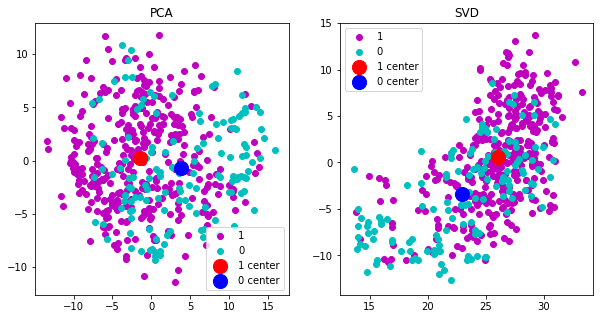

 KMeans  166 - 334 - 33.2
 AgglomerativeClustering 128 - 372 - 25.6
===== wide_resnet101_2 =====
PCA explained variance ratio  [0.15338526 0.11322272]
PCA singular values           [113.94598467  97.89804155]
SVD explained variance ratio  [0.04297368 0.13474235]
SVD singular values           [478.50232 107.08393]


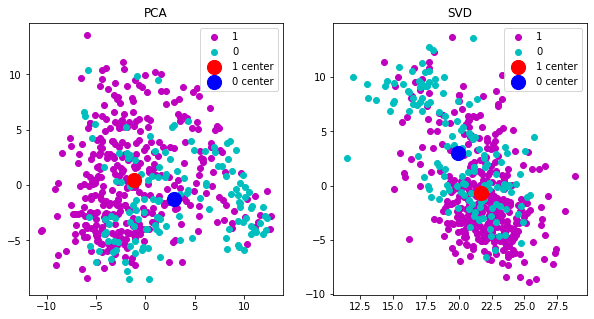

 KMeans  345 - 155 - 69.0
 AgglomerativeClustering 291 - 209 - 58.199999999999996
===== vgg16 =====
PCA explained variance ratio  [0.05572638 0.02865846]
PCA singular values           [336.02436386 240.97211411]
SVD explained variance ratio  [0.02615543 0.0344888 ]
SVD singular values           [1094.5356   268.15283]


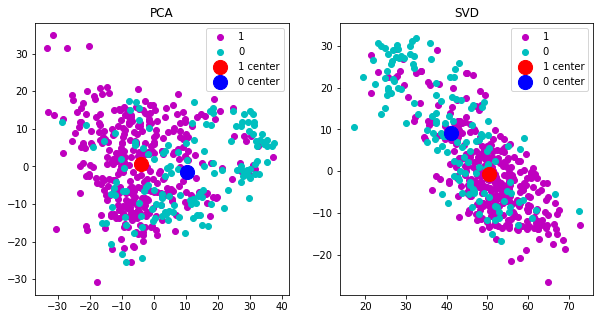

 KMeans  132 - 368 - 26.400000000000002
 AgglomerativeClustering 114 - 386 - 22.8
Wall time: 1h 23min 53s


In [88]:
%%time
for i in ['resnet18', 'resnet34', 'resnet50', 'mobilenet_v2', 'densenet201', 'alexnet', 'resnet152', 'resnext101_32x8d', 'wide_resnet101_2', 'vgg16']:
#for i in ['resnet18']:
    print("=====", i, "=====")
    vectors = get_vectors(i)
    plot_PCA_SVD(vectors)
    kmeans_ac(vectors)